# Baseline analysis done on the 1hr Sun data

In [1]:
import ugradio
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.table as Table
from datetime import datetime
from datetime import timedelta
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from tqdm import tqdm


%matplotlib inline
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

No module named 'rtlsdr'


## Loading in the data 

In [2]:
volts, times = np.load('Data/1hr_Sun_data.npy')

volts, times = volts[100:], times[100:]

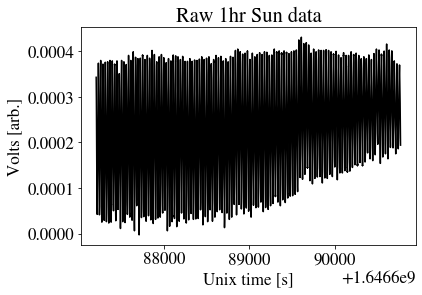

In [3]:
plt.figure()
plt.title('Raw 1hr Sun data')
plt.plot(times, volts, 'k')
plt.xlabel('Unix time [s]')
plt.ylabel('Volts [arb.]')
plt.show()

## Times of observations

In [4]:
beginning_time = min(times)
ending_time = max(times)

beginning_local_time = ugradio.timing.local_time(beginning_time)
ending_local_time = ugradio.timing.local_time(ending_time)

beginning_jd = ugradio.timing.julian_date(beginning_time)
ending_jd = ugradio.timing.julian_date(ending_time)


print('Beginning time in local time (PST):', beginning_local_time, '\nEnding time in local time (PST):', ending_local_time)

print('\nBeginning JD:', beginning_jd, '\nEnding JD:', ending_jd)

lon, lat = ugradio.coord.nch.lon, ugradio.coord.nch.lat

jds = ugradio.timing.julian_date(times) # julian dates
LSTs = ugradio.timing.lst(jd=jds, lon=lon) # local sidereal times -- radians

ra_deg, dec_deg = ugradio.coord.sunpos(beginning_jd) # initial ra and dec, degrees
ra_rad, dec_rad = (np.pi/180)*ra_deg, (np.pi/180)*dec_deg #radians
has = LSTs - ra_rad # hour angles -- radians

Beginning time in local time (PST): Mon Mar  7 13:06:44 2022 
Ending time in local time (PST): Mon Mar  7 14:06:08 2022

Beginning JD: 2459646.3796870033 
Ending JD: 2459646.420937031


In [12]:
ugradio.coord.nch??


## Analysis of Baseline

In [5]:
c = 3e8 # m/s
ν = 10.5e9 #Hz
λ = c/ν

In [6]:
h_s = np.linspace(has[0],(has[0]+15*(np.pi/180)),len(jds)) #h_s for 1hr sun data 

h_s

array([0.20916296, 0.20917763, 0.2091923 , ..., 0.470933  , 0.47094767,
       0.47096234])

In [7]:
### Creating Models ###

def ν_τg(h_s, B_ew, B_ns, δ, λ):
    L = lat
    return (((B_ew / λ) * np.cos(δ)) * np.sin(h_s) + ((B_ns / λ) * np.sin(L) * np.cos(δ)) * np.cos(h_s))

def fringe_model(ν_τg, A, B):
    return A * np.cos(2 * np.pi * ν_τg) + B * np.sin(2 * np.pi * ν_τg)
    

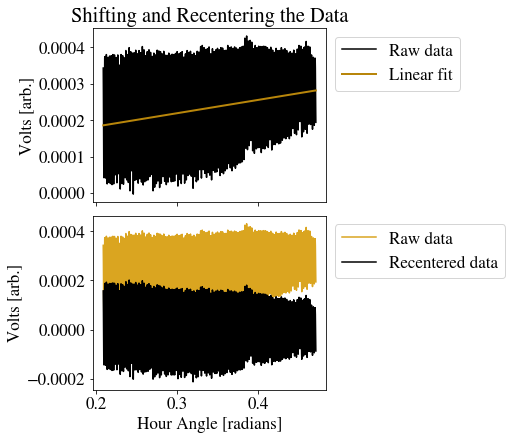

Slope: 0.0003660266006416476 
y-int: 0.0001091799887080246


In [8]:
v = ν_τg(h_s, 14.7106, 1.820, dec_rad, λ)


linear_model = np.polyfit(h_s, volts, deg=1)
m, b = linear_model

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(7,6), constrained_layout=True, sharex=True)

ax0.set_title('Shifting and Recentering the Data')

ax0.plot(h_s, volts, color='k', label='Raw data')
ax0.plot(h_s, m*h_s + b, 'darkgoldenrod', lw=2, label='Linear fit')
ax0.set_ylabel('Volts [arb.]')
ax0.legend(bbox_to_anchor=(1,1), loc='upper left')

ax1.plot(h_s, volts, color='goldenrod', label='Raw data')
ax1.plot(h_s, volts - (m*h_s + b), color='k', label='Recentered data')
ax1.set_xlabel('Hour Angle [radians]')
ax1.set_ylabel('Volts [arb.]')
ax1.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.show()

print('Slope:', m, '\ny-int:', b)

In [162]:
lobe_1hr = np.array([h_s, volts - (m*h_s + b)])

# resolution = 40


def compute_χ_sq(data, resolution, xmin, xmax, ymin, ymax):
    
    B_ew, B_ns = np.linspace(xmin, xmax, resolution), np.linspace(ymin, ymax, resolution)
    B_EW, B_NS = np.meshgrid(B_ew, B_ns)
    
    ydata = data[1]
    h_s = data[0]
    
    χ_sq = np.zeros(B_EW.shape)
    χ_sq_r = np.zeros(B_EW.shape)
    sigma = .00002
    
    for i in tqdm(range(len(B_ew))):
        for j in range(len(B_ns)):
            vs = ν_τg(h_s, B_EW[i,j], B_NS[i,j], dec_rad, λ)  # Try new baselines
            p0 = np.array([0.0002,0.0003]) # A, B Guesses
            params, cov = scipy.optimize.curve_fit(fringe_model, vs, ydata, p0)
            chi_squared = np.sum(((fringe_model(vs, *params)-ydata)/sigma)**2)
            reduced_chi_squared = (chi_squared)/(len(vs)-len(params))
            χ_sq[i,j] = chi_squared
            χ_sq_r[i,j] = reduced_chi_squared
            
            

    return χ_sq, χ_sq_r


In [146]:
xmin, xmax = 14.717, 14.723
ymin,ymax = 1.78, 1.87
res = 150

χ_sq_1, χ_sq_r_1 = compute_χ_sq(lobe_1hr, res, xmin, xmax, ymin, ymax)

100%|██████████| 150/150 [04:32<00:00,  1.82s/it]


In [147]:
χ_sq_final = χ_sq_1

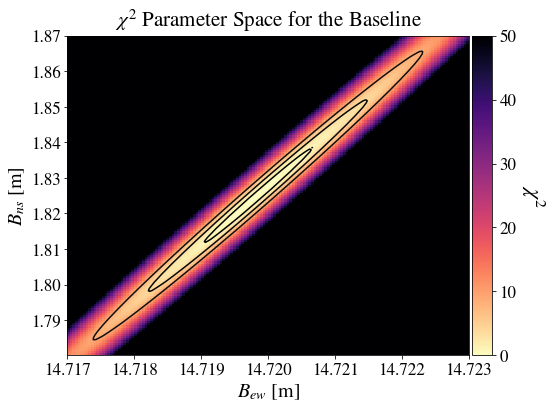

In [148]:
# %matplotlib notebook

# plt.figure()


extent=[xmin, xmax, ymin, ymax]
levels = [1, 4, 9]
f, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_title("$\chi^2$ Parameter Space for the Baseline", pad=10, fontsize=21)

cs = ax.contour(χ_sq_final - np.min(χ_sq_final), 
                levels, cmap="Greys_r", origin='lower', linewidths=1.5, extent=extent, vmax=150)

fmt = {}
strs = ['1σ', '2σ', '3σ']
for l, s in zip(cs.levels, strs):
    fmt[l] = s

    
# man = [[14.7206, 1.83784], [14.7185, 1.80], [14.7191, 1.78945]]
# plt.clabel(cs, cs.levels, fmt=fmt, inline=1, manual=man, fontsize=20)    

im = ax.imshow(χ_sq_final - np.min(χ_sq_final), origin="lower",
               extent=extent, cmap="magma_r", aspect="auto", vmax=50)


ax.set_xlabel("$B_{ew}$ [m]", fontsize=20)
ax.set_ylabel("$B_{ns}$ [m]", fontsize=20)
ax.set_ylim(ymin+0.0001, ymax)
ax.set_xlim(xmin, xmax)


divider1 = axgrid.make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax1)
cbar.set_label(label= '$\\chi^2$', rotation=270, labelpad=30, fontsize=22)
plt.tight_layout()
plt.show()

In [163]:
χ_sq_final_r_bf = np.max(χ_sq_final / (len(lobe_1hr[0]) - 2))
print(f"We report a reduced χ^2 value for the best fit of {χ_sq_final_r_bf}")

We report a reduced χ^2 value for the best fit of 1.495967417785822


In [164]:
def compute_sigma(χ_sq, resolution, xmin, xmax, ymin, ymax, nσ):
    
    shifted = χ_sq - np.min(χ_sq) 
    
    B_ew, B_ns = np.linspace(xmin, xmax, resolution), np.linspace(ymin, ymax, resolution)
    B_EW, B_NS = np.meshgrid(B_ew, B_ns)

    xs = np.where(np.isclose(shifted, nσ**2, rtol=1e-1))[0][:]
    ys = np.where(np.isclose(shifted, nσ**2, rtol=1e-1))[1][:]

    max_B_ew, min_B_ew = np.max(B_EW[xs,ys]),np.min(B_EW[xs,ys])
    max_B_ns, min_B_ns = np.max(B_NS[xs,ys]),np.min(B_NS[xs,ys])

    bf_B_ew = B_EW[np.where(shifted == np.min(shifted))][0]
    bf_B_ns = B_NS[np.where(shifted == np.min(shifted))][0]

    print("The North-South Baseline is {0:0.3f} + {1:0.3f} - {2:0.3f} [m] to {3}σ".format(bf_B_ns, 
                                                                                  max_B_ns - bf_B_ns, 
                                                                                  bf_B_ns - min_B_ns, nσ))

    print("The East-West Baseline is {0:0.3f} + {1:0.3f} - {2:0.3f} [m] to {3}σ".format(bf_B_ew, 
                                                                                  max_B_ew - bf_B_ew, 
                                                                                  bf_B_ew - min_B_ew, nσ))

    
compute_sigma(χ_sq_final, res , xmin, xmax, ymin, ymax, 2)
    

The North-South Baseline is 1.825 + 0.028 - 0.028 [m] to 2σ
The East-West Baseline is 14.720 + 0.002 - 0.002 [m] to 2σ
